<a href="https://www.goes-r.gov/">
<img src='./GOES-R_logo_small.png' style="height:150px" align=right alt="GOES16 Logo">
</a>

# GOES-16: True Color Recipe
__Brian Blaylock__   
__May 25, 2018__  
| blaylock@gmail.com | [_website_](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/home.html) |  


This Python notebook shows how to make a GOES-16 True Color image from the Level 2 data files. It also shows how to plot the data on a `Basemap` and how to transform the data onto different map projections using `pyproj`.

The True Color product is an RGB composite image of the following three channels:

|          | Wavelength   | Channel | Description |
|----------|:------------:|:-------:|:-----------:|
| **Red**  | 0.64 &#181;m |    2    | Red Visible |
| **Green**| 0.86 &#181;m |    3    | Veggie Near-IR|
| **Blue** | 0.47 &#181;m |    1    | Blue Visible|


---

### Download GOES-16 Data
For this demo, you first need a GOES-16 data file. You can get GOES-16 files from [NOAA's Amazon S3 GOES Archive](https://aws.amazon.com/public-datasets/goes/). I created a [web interface](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi) to easily download files from the Amazon archive. For routine downloads, you should use `rclone` or `AWS CLI`. 

This example uses the **[level 2 _multiband_ formatted file for the _CONUS_ domain (ABI-L2-MCMIPC)]**(http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi?domain=C&product=ABI-L2-MCMIP&hour=0). Unlike the full-resoluiton individual channel files, these multiband files contains all 16 bands in one file on the same 2 km grid. Some additional work, not described here, is needed if you want the full 1 km resolution true color images (i.e. you would need to download three separate files for each RGB channels and subsample the red channel because its resolution is 0.5 km). I use the multiband formated file because it's easy to utilize all the bands on the same grid. More information about the file can be found on [Amazon AWS](https://docs.opendata.aws/noaa-goes16/cics-readme.html).

----------

The methods shown here are stitched together from the following useful information I found online:
- [ABI Bands Quick Information Guides](https://www.goes-r.gov/education/ABI-bands-quick-info.html)
- [Open Commons Consortium](http://edc.occ-data.org/goes16/python/)
- [GeoNetCast Blog](https://geonetcast.wordpress.com/2017/07/25/geonetclass-manipulating-goes-16-data-with-python-part-vi/)
- [Proj documentation](http://proj4.org/projections/geos.html)
- [Pyproj documentation](http://jswhit.github.io/pyproj/pyproj.Proj-class.html)


### First, import some libraries we will use

In [1]:
%matplotlib inline

from netCDF4 import Dataset
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from pyproj import Proj

### Open and Read the GOES-16 NetCDF File
I previously downloaded the following file from Amazon Web Services

Example File Name:

>OR_ABI-L2-MCMIPC-M3_G16_
<span style='color:red'>s20181781922189</span>_
<span style='color:blue'>e20181781924562</span>_
<span style='color:green'>c20181781925075</span>.nc

    OR     - Indicates the system is operational
    ABI    - Instrument type
    L2     - Level 2 Data
    MCMIP  - Multichannel Cloud and Moisture Imagery products
    c      - CONUS file (every 5 minutes).
    M3     - Scan mode
    G16    - GOES-16 (G17 for future GOES-17)
    s##### - Scan start: 4 digit year, 3 digit day of year (julian day), hour, minute, second, tenth second
    e##### - Scan end:
    c##### - File Creation
    .nc    - NetCDF file extension


In [155]:
FILE = 'OR_ABI-L2-MCMIPC-M3_G16_s20181781922189_e20181781924562_c20181781925075.nc'
X = xarray.open_dataset('OR_ABI-L2-MCMIPC-M3_G16_s20181781922189_e20181781924562_c20181781925075.nc')

### Date and Time Information
There is one file for each GOES scan sequence. There are several different time stamps in this file, which are also found in the file's name.

In [216]:
# Scan's start time, converted to datetime object
scan_start = datetime.strptime(X.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

# Scan's end time, converted to datetime object
scan_end = datetime.strptime(X.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')

# File creation time, convert to datetime object
file_created = datetime.strptime(X.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')

# The 't' variable is the scan's midpoint time
# I'm not a fan of numpy datetime, so I convert it to a regular datetime object
midpoint = str(X['t'].data)[:-8]
scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')

print('Scan Start   : %s' % scan_start)
print('Scan midpoint: %s' % scan_mid)
print('Scan End     : %s' % scan_end)
print('File Created : %s' % file_created)

Scan Start   : 2018-06-27 19:22:18.900000
Scan midpoint: 2018-06-27 19:23:37.600000
Scan End     : 2018-06-27 19:24:56.200000
File Created : 2018-06-27 19:25:07.500000


---

### True Color Recipe
You make a color image by creating a Red-Green-Blue composite of three different channels.


|               | **RED**      | **GREEN**      | **BLUE**     |
|---------------|:------------:|:--------------:|:------------:|
| **Name**      | Red Visibile | Near-IR Veggie | Blue Visible |
| **Wavelength**| 0.64 &#181;m | 0.86 &#181;m   | 0.47 &#181;m |
| **Channel**   |      2       |       3        |      1       |
| **Units**     | reflectance range [0-1] | reflectance range [0-1]  | reflectance range [0-1] |

The GREEN "veggie" channel on GOES-16 does not measure visible green. Instead, it measures a near-infrared band sensitive to chlorophyll. We could use that channel in place of green, but it would make the green in our satellite image look too vibrant. Instead, we will tone-down the green channel by interpolating the value to simulate a _natural green_ color. I followed the instructions [here](http://edc.occ-data.org/goes16/python/) for applying a gamma correction and calculating the "true green" value.

\begin{equation}
TrueGreen = (0.48358168*RED) + (0.45706946*BLUE) + (0.06038137*GREEN)
\end{equation}

The multiband formated file we loaded is convenient becuase all the GOES channels are in the same NetCDF file.

In [217]:
# Confirm that each band is the wavelength we are interested in
for band in [2, 3, 1]:
    print("%s is %.2f %s" % (X['band_wavelength_C%02d' % band].long_name,
                             X['band_wavelength_C%02d' % band][0],
                             X['band_wavelength_C%02d' % band].units))

ABI band 2 central wavelength is 0.64 um
ABI band 3 central wavelength is 0.87 um
ABI band 1 central wavelength is 0.47 um


In [218]:
# Load the three channels into appripriate R, G, and B
R = X['CMI_C02'].data
G = X['CMI_C03'].data
B = X['CMI_C01'].data

In [219]:
# Apply range limits for each channel becuase RGB values must be between 0 and 1
R = np.maximum(R, 0)
G = np.maximum(G, 0)
B = np.maximum(B, 0)

R = np.minimum(R, 1)
G = np.minimum(G, 1)
B = np.minimum(B, 1)

In [220]:
# Apply the gamma correction
gamma = 0.4
R = np.power(R, gamma)
G = np.power(G, gamma)
B = np.power(B, gamma)

In [221]:
# Calculate the "True" Green
G_true = 0.48358168 * R + 0.45706946 * B + 0.06038137 * G
G_true = np.maximum(G_true, 0)
G_true = np.minimum(G_true, 1)

In [222]:
# The final RGB array :)
RGB = np.dstack([R, G_true, B])

Note: Notice we used the numpy masked_array routine of `dstack` rather than the normal `dstack`

### Simple Image
Use `imshow` to get a simple look at the RGB image we created

Text(1,1,'19:22 UTC 27 June 2018')

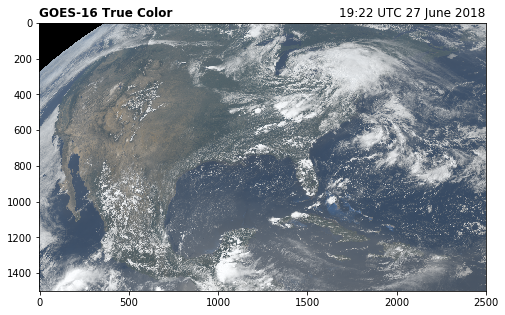

In [223]:
plt.figure(figsize=[8, 8])
plt.imshow(RGB)

plt.title('GOES-16 True Color', fontweight='semibold', loc='left', fontsize=12)
plt.title('%s' % scan_start.strftime('%H:%M UTC %d %B %Y'), loc='right')

### Plot on a Basemap: Geostationay Projection
The problem with the above image is that it is not georeferenced. We do not know where in the world each pixel lies. The GOES-16 file contains all the metadata needed to understand the map projection of the image. We will use this data to plot the image on a basemap. The image is in a [geostationary projection](http://proj4.org/projections/geos.html).

In [224]:
X['goes_imager_projection']

<xarray.DataArray 'goes_imager_projection' ()>
array(-2147483647, dtype=int32)
Coordinates:
    t        datetime64[ns] 2018-06-27T19:23:37.629063040
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    long_name:                       GOES-R ABI fixed grid projection
    grid_mapping_name:               geostationary
    perspective_point_height:        35786023.0
    semi_major_axis:                 6378137.0
    semi_minor_axis:                 6356752.31414
    inverse_flattening:              298.2572221
    latitude_of_projection_origin:   0.0
    longitude_of_projection_origin:  -75.0
    sweep_angle_axis:                x

In [227]:
# Satellite height
sat_h = C.variables['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = C.variables['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = C.variables['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates equals
# the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)
X = C.variables['x'][:] * sat_h
Y = C.variables['y'][:] * sat_h

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [136]:
# The geostationary projection is perhaps the easiest way to plot the image on a map.
# Essentially, we are stretching the image across a map with the same projection and dimensions.
m = Basemap(projection='geos', lon_0=sat_lon,
            resolution='i', area_thresh=5000,
            llcrnrx=X.min(),llcrnry=Y.min(),
            urcrnrx=X.max(),urcrnry=Y.max())

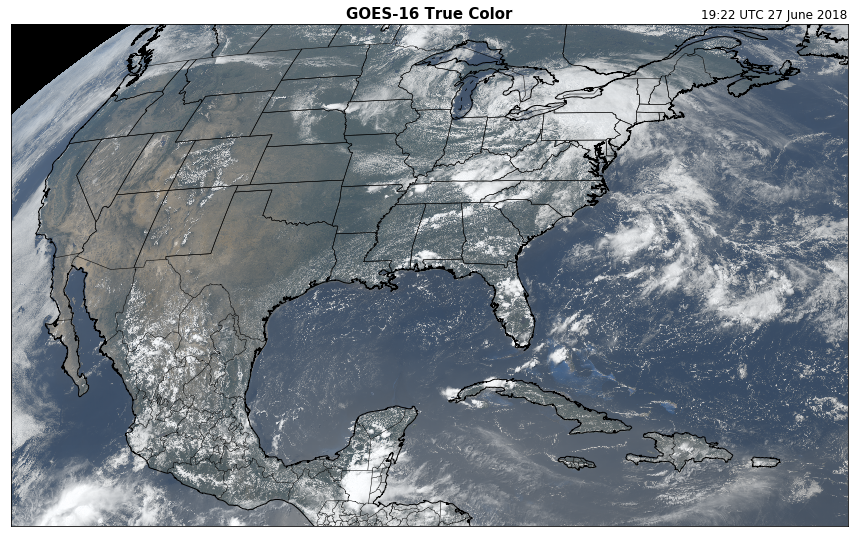

In [137]:
plt.figure(1, figsize=[15, 12])
m.imshow(np.flipud(RGB)) # Remember, "images" are upside down, so flip up/down
m.drawcoastlines()
m.drawcountries()
m.drawstates()


plt.title('GOES-16 True Color', fontweight='semibold', fontsize=15)
plt.title('%s' % scan_start.strftime('%H:%M UTC %d %B %Y'), loc='right');

### What about for other projections?

The data pixels are still not georeferenced. We will use the metadata and `pyproj` to calculate the latitude and longitude of each pixel so we can project the image onto other maps. This is done by using an inverse transformation of the map projection object, `p`, of the map coordinates given by X and Y. Since the satellite doesn't move, you can do this calculation once and save the latitude and longitude arrays for later use. I have saved these arrays in an HDF5 file [here](https://pando-rgw01.chpc.utah.edu/GOES16/goes16_conus_latlon_east.h5) you may use.

#### The magic function: `pyproj.Proj`
This function creates a map projection object of the geostationary projection.

In [138]:
# map object with pyproj
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

In [139]:
# Convert map points to latitude and longitude with the magic provided by Pyproj
XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)

lats[np.isnan(R)] = np.nan
lons[np.isnan(R)] = np.nan
# ^ Please take a moment and appreciate those two lines. Before adding this seemingly simple and unimportant step,
#   the plots were getting messed up. I contemplated why that was happening during a 2-hr commute home, while cooking
#   dinner, watching an hour of Gone With the Wind with my wife, and while sleeping for 7 hours. At breakfast I figured
#   it out! I had to mask the empty data with nans like I did with the RGB values. During the first 2 minutes of work,
#   I added these two lines and now everything from here on down works!

 ### Plot on a Basemap: Lambert Conformal Projection
 I am going to project the GOES-16 data on the Lambert Conformal Projection used by the [HRRR](https://rapidrefresh.noaa.gov/hrrr/) model.

In [140]:
# Make a new map object for the HRRR model domain map projection
mH = Basemap(resolution='i', projection='lcc', area_thresh=5000, \
             width=1800*3000, height=1060*3000, \
             lat_1=38.5, lat_2=38.5, \
             lat_0=38.5, lon_0=-97.5)

We can't simply plot the reprojected image with `imshow` because the pixels are spaced irregularly. We have to use `pcolormesh`, which is not a trivial task. We need to create a color tuple for each pixel. Details on doing this are on stackoverflow [here](https://stackoverflow.com/questions/29232439/plotting-an-irregularly-spaced-rgb-image-in-python) and [here](https://stackoverflow.com/questions/41389335/how-to-plot-geolocated-rgb-data-faster-using-python-basemap). Below is my method.

In [141]:
# Create a color tuple for pcolormesh
rgb = RGB[:,:-1,:] # Using one less column is very imporant, else your image will be scrambled! (This is the stange nature of pcolormesh)
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3) # flatten array, becuase that's what pcolormesh wants.
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1) # adding an alpha channel will plot faster, according to stackoverflow. Not sure why.

In [148]:
# Now we can plot the GOES data on the HRRR map domain and projection
plt.figure(figsize=[15, 12])

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in greater
  if np.any((result < 0) | (result > 1)):


RuntimeError: Can not put single artist in more than one figure

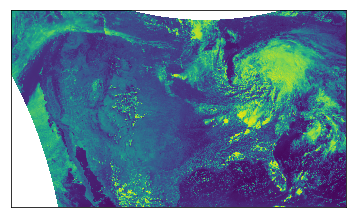

In [149]:
# The values of R are ignored becuase we plot the color in colorTuple, but pcolormesh still needs its shape.
newmap = mH.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, latlon=True)
newmap.set_array(None) # without this line the linewidth is set to zero, but the RGB colorTuple is ignored. I don't know why.

mH.drawcoastlines()
mH.drawcountries()
mH.drawstates()

plt.title('GOES-16 True Color', fontweight='semibold', fontsize=15)
plt.title('%s' % scan_start.strftime('%H:%M UTC %d %B %Y'), loc='right');

Wa-la! You have just projected the GOES-16 data on the HRRR map projection and domain :)

--------

 ### Plot on a Basemap: Cylindrical Projection
 It is also possible to zoom in on a specific location. This shows a True Color image for over Northern Utah

In [23]:
# Location of Utah
l = {'latitude': 39.75,
     'longitude': -111.5}

# Draw zoomed map
mZ = Basemap(resolution='i', projection='cyl', area_thresh=50000,\
             llcrnrlon=l['longitude']-13.25, llcrnrlat=l['latitude']-13.25,\
             urcrnrlon=l['longitude']+13.25, urcrnrlat=l['latitude']+13.25,)

Text(1,1,'19:22 UTC 27 June 2018')

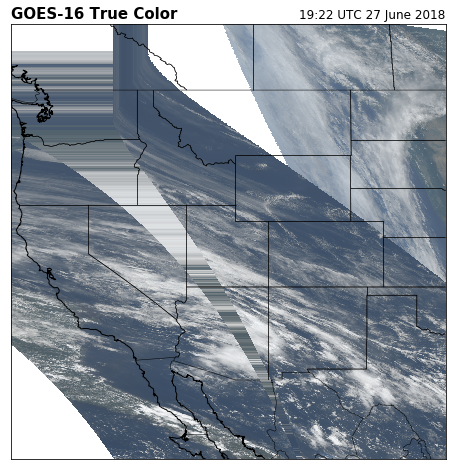

In [26]:
# Now we can plot the GOES data on a zoomed in map centered Utah
plt.figure(figsize=[8, 8])

# The values of R are ignored becuase we plot the color in colorTuple, but pcolormesh still needs its shape.
newmap = mZ.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, latlon=True)
newmap.set_array(None) # without this line, the linewidth is set to zero, but the RGB colorTuple is ignored. I don't know why.

mZ.drawcoastlines()
mZ.drawcountries()
mZ.drawstates()

plt.title('GOES-16 True Color', fontweight='semibold', loc='left', fontsize=15)
plt.title('%s' % scan_start.strftime('%H:%M UTC %d %B %Y'), loc='right')

---
# Overlay Nighttime IR when dark
At nighttime, the visible wavlengths don't measure anything. The area is black. But there is still information from the satellite and we can still see clouds at night. To overcome this, we can plot the True Color Image with the Clean IR on top. 

_**First, open the file and do normal stuff for true color image**_

In [22]:
half_night_scan = '/uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/ABI-L2-MCMIPC/20180525/OR_ABI-L2-MCMIPC-M3_G16_s20181450027251_e20181450030024_c20181450030129.nc'
Cnight = Dataset(half_night_scan, 'r')

# Load the RGB arrays
R = Cnight.variables['CMI_C02'][:].data
G = Cnight.variables['CMI_C03'][:].data
B = Cnight.variables['CMI_C01'][:].data

# Turn empty values into nans
R[R==-1] = np.nan
G[G==-1] = np.nan
B[B==-1] = np.nan

# Apply range limits for each channel becuase RGB values must be between 0 and 1
R = np.maximum(R, 0)
R = np.minimum(R, 1)
G = np.maximum(G, 0)
G = np.minimum(G, 1)
B = np.maximum(B, 0)
B = np.minimum(B, 1)

# Apply the gamma correction
gamma = 0.4
R = np.power(R, gamma)
G = np.power(G, gamma)
B = np.power(B, gamma)

# Calculate the "True" Green
G_true = 0.48358168 * R + 0.45706946 * B + 0.06038137 * G
G_true = np.maximum(G_true, 0)
G_true = np.minimum(G_true, 1)

FileNotFoundError: [Errno 2] No such file or directory: b'/uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/ABI-L2-MCMIPC/20180525/OR_ABI-L2-MCMIPC-M3_G16_s20181450027251_e20181450030024_c20181450030129.nc'

_**Load the Clear IR (Band 13) which is 10.3 um**_  
Clean IR has units of Kelvin, so we need to normalize the temperature array between a range of values.

In [ ]:
cleanIR = Cnight.variables['CMI_C13'][:].data
cleanIR[cleanIR==-1] = np.nan

# Apply range limits for clean IR channel
cleanIR = np.maximum(cleanIR, 90)
cleanIR = np.minimum(cleanIR, 313)

# Normalize the channel between a range
cleanIR = (cleanIR-90)/(313-90)

# Invert colors
cleanIR = 1 - cleanIR

# Lessen the brightness of the coldest clouds so they don't appear so bright near the day/night line
cleanIR = cleanIR/1.5

##### Show the True Color and the clean IR images
We want to overlay these so the clean IR will fill in the black area on the True Color image

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.imshow(np.dstack([R, G_true, B]))
ax2.imshow(np.dstack([cleanIR, cleanIR, cleanIR]))
ax1.set_title('True Color')
ax2.set_title('Clean IR')

To fill in the black area on the True Color image we will set the RGB channel to equal the maximum value between the visible channels and the IR channels. This requies a bit of interpretation beucase if the Clean IR has bright clouds in the daylight, they will replace the color values in the true color image. Still, it makes a nice plot and allows you to see clouds when it is nightime. That is why we lessened the brightness of the cleanIR by dividing the values by 1.5 in the lines above.

In [ ]:
RGB_IR = np.dstack([np.maximum(R, cleanIR), np.maximum(G_true, cleanIR), np.maximum(B, cleanIR)])

In [ ]:
plt.figure(figsize=[15, 12])
m.imshow(np.flipud(RGB_IR)) # Remember, "images" are upside down, so flip up/down
m.drawcoastlines()
m.drawcountries()
m.drawstates()

plt.title('GOES-16 True Color and Night IR', fontweight='semibold', fontsize=15)
plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'), loc='right')

---
# Adjust Image Contrast
You can make the colors pop out more if you adjust the image contrast.

Note: you should adjust the contrast _before_ you add in the Clean IR channel.

In [ ]:
def contrast_correction(color, contrast):
    """
    Modify the contrast of an R, G, or B color channel
    See: #www.dfstudios.co.uk/articles/programming/image-programming-algorithms/image-processing-algorithms-part-5-contrast-adjustment/

    Input:
        C - contrast level
    """
    F = (259*(contrast + 255))/(255.*259-contrast)
    COLOR = F*(color-.5)+.5
    COLOR = np.minimum(COLOR, 1)
    COLOR = np.maximum(COLOR, 0)
    return COLOR

# Modify the RGB color contrast:
contrast = 125

RGB_contrast = contrast_correction(np.dstack([R, G_true, B]), contrast)
RGB_contrast_IR = np.dstack([np.maximum(RGB_contrast[:,:,0], cleanIR), np.maximum(RGB_contrast[:,:,1], cleanIR), np.maximum(RGB_contrast[:,:,2], cleanIR)])

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,12))
plt.sca(ax1)
m.imshow(np.flipud(RGB_IR))
m.drawcoastlines()
m.drawcountries()
plt.title('True Color and Night IR')

plt.sca(ax2)
m.imshow(np.flipud(RGB_contrast_IR))
m.drawcoastlines()
m.drawcountries()
plt.title('Contrast=%s' % contrast)

plt.subplots_adjust(wspace=.02)

----

---
# GOES-16 with HRRR Overlay
Ultimately, I wanted to overlay HRRR analyses over the GOES-16 images. I don't show how I got the HRRR data here, but below is a sample image of HRRR simulated reflectivity and 500 mb heights on September 10, 2017 at 1800 UTC. (If you are interestd in HRRR data, see here: http://hrrr.chpc.utah.edu/)

In [ ]:
import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2/')
from BB_downloads.HRRR_S3 import get_hrrr_variable
H = get_hrrr_variable(DATE, 'REFC:entire', verbose=False)
H500 = get_hrrr_variable(DATE, 'HGT:500 mb', verbose=False)

In [ ]:
# Mask points with no reflectivity
dBZ = H['value']
dBZ = np.ma.array(dBZ)
dBZ[dBZ == -10] = np.ma.masked

plt.figure(figsize=[10,8])
# Plot the GOES image
newmap = mH.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, latlon=True)
newmap.set_array(None) # without this, the linewidth is set to zero, but the RGB color is ignored

# Plot the HRRR reflectivity
mH.pcolormesh(H['lon'], H['lat'], dBZ, latlon=True,
              cmap='gist_ncar',
              vmax=80, vmin=0)
cb = plt.colorbar(orientation='horizontal', shrink=.7, pad=.01)
cb.set_label('Simulated Radar Reflectivity (dBZ)')

# Plot the HRRR 500 mb height
cs = mH.contour(H500['lon'], H500['lat'], H500['value'], latlon=True,
                colors='k',
                linewidths=2,
                levels=range(4980, 6100, 60))
plt.clabel(cs, fmt = '%1.0f', fontsize=12)

# Plot other map elements
mH.drawstates()
mH.drawcountries()
mH.drawcoastlines()

# Title
date_fmt = '%B %d, %Y %H:%M'
plt.title('GOES-16 True Color\n%s' % DATE.strftime(date_fmt), loc='left')
plt.title('HRRR Simulated Reflectivity and 500 mb Height\n%s' % H['valid'].strftime(date_fmt), loc='right')

# Can we make plots for a Mesoscale scan?
Yes. Yes we can.

In [ ]:
# M1 is for the Mesoscale1 NetCDF file
M1_file = 'OR_ABI-L2-MCMIPM1-M3_G16_s20172531800245_e20172531800302_c20172531800373.nc'
M1 = Dataset(M1_file, 'r')

# Load the RGB arrays
R = M1.variables['CMI_C02'][:]
G = M1.variables['CMI_C03'][:]
B = M1.variables['CMI_C01'][:]

# Turn empty values into nans
R[R==-1] = np.nan
G[G==-1] = np.nan
B[B==-1] = np.nan

# Apply range limits for each channel becuase RGB values must be between 0 and 1
R = np.maximum(R, 0)
R = np.minimum(R, 1)
G = np.maximum(G, 0)
G = np.minimum(G, 1)
B = np.maximum(B, 0)
B = np.minimum(B, 1)

# Apply the gamma correction
gamma = 0.4
R = np.power(R, gamma)
G = np.power(G, gamma)
B = np.power(B, gamma)

# Calculate the "True" Green
G_true = 0.48358168 * R + 0.45706946 * B + 0.06038137 * G
G_true = np.maximum(G_true, 0)
G_true = np.minimum(G_true, 1)

# The final RGB array :)
RGB = np.dstack([R, G_true, B])

# Seconds since 2000-01-01 12:00:00
add_seconds = M1.variables['t'][0]
DATE = datetime(2000, 1, 1, 12) + timedelta(seconds=add_seconds)

# Satellite height
sat_h = M1.variables['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = M1.variables['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = M1.variables['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates equals
# the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)
X = M1.variables['x'][:] * sat_h
Y = M1.variables['y'][:] * sat_h

In [ ]:
# Plot on HRRR domain:

# map object with pyproj
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

# Convert map points to latitude and longitude with the magic provided by Pyproj
XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)

# Make a new map object for the HRRR model domain map projection
mH = Basemap(resolution='i', projection='lcc', area_thresh=1500, \
            width=1800*3000, height=1060*3000, \
            lat_1=38.5, lat_2=38.5, \
            lat_0=38.5, lon_0=-97.5)

xH, yH = mH(lons, lats)

# Create a color tuple for pcolormesh
rgb = RGB[:,:-1,:] # Using one less column is very imporant, else your image will be scrambled! (This is the stange nature of pcolormesh)
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3) # flatten array, becuase that's what pcolormesh wants.
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1) # adding an alpha channel will plot faster?? according to stackoverflow.

# Now we can plot the GOES data on the HRRR map domain and projection
plt.figure(figsize=[10, 8])

# The values of R are ignored becuase we plot the color in colorTuple, but pcolormesh still needs its shape.
newmap = mH.pcolormesh(xH, yH, R, color=colorTuple, linewidth=0)
newmap.set_array(None) # without this line, the linewidth is set to zero, but the RGB colorTuple is ignored. I don't know why.

mH.drawstates()
mH.drawcountries()
mH.drawcoastlines()

plt.title('GOES-16 True Color', fontweight='semibold', fontsize=15)
plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'), loc='right')
plt.title('Mesoscale Section 1', loc='left')

In [ ]:
# The geostationary projection
mM1 = Basemap(projection='geos', lon_0=sat_lon, resolution='i',
            llcrnrx=X.min(),llcrnry=Y.min(),
            urcrnrx=X.max(),urcrnry=Y.max())

In [ ]:
plt.figure(figsize=[10, 10])
mM1.imshow(np.flipud(RGB)) # Remember, "images" are upside down, so flip up/down
mM1.drawcoastlines()
mM1.drawcountries()
mM1.drawstates()

plt.title('GOES-16 True Color', fontweight='semibold', fontsize=15, loc='left')
plt.title('Mesoscale Scan 1\n%s' % DATE.strftime('%H:%M UTC %d %B %Y'), loc='right')

----

# Can we do this for a Full Disk Scan? It's possible...
but data files are so large, plotting anythig is very slow. I don't need to do this, so I wont worry about it.

In [ ]:
# F is for the Full Disk NetCDF file
F_file = 'OR_ABI-L2-MCMIPF-M3_G16_s20172531745358_e20172531756131_c20172531756202.nc'
F = Dataset(F_file, 'r')

# Load the RGB arrays
R = F.variables['CMI_C02'][:].data
G = F.variables['CMI_C03'][:].data
B = F.variables['CMI_C01'][:].data

# Turn empty values into nans
R[R==-1] = np.nan
G[G==-1] = np.nan
B[B==-1] = np.nan

# Apply range limits for each channel becuase RGB values must be between 0 and 1
R = np.maximum(R, 0)
R = np.minimum(R, 1)
G = np.maximum(G, 0)
G = np.minimum(G, 1)
B = np.maximum(B, 0)
B = np.minimum(B, 1)

# Apply the gamma correction
gamma = 0.4
R = np.power(R, gamma)
G = np.power(G, gamma)
B = np.power(B, gamma)

# Calculate the "True" Green
G_true = 0.48358168 * R + 0.45706946 * B + 0.06038137 * G
G_true = np.maximum(G_true, 0)
G_true = np.minimum(G_true, 1)

# The final RGB array :)
RGB = np.dstack([R, G_true, B])


In [ ]:
# Seconds since 2000-01-01 12:00:00
add_seconds = F.variables['t'][0]
DATE = datetime(2000, 1, 1, 12) + timedelta(seconds=add_seconds)

# Satellite height
sat_h = F.variables['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = F.variables['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = F.variables['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates equals
# the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)
X = F.variables['x'][:] * sat_h
Y = F.variables['y'][:] * sat_h

##### Geostationary projection is easy

In [ ]:
# The geostationary projection
mF = Basemap(projection='geos', lon_0='-89.5',
            llcrnrx=X.min(),llcrnry=Y.min(),
            urcrnrx=X.max(),urcrnry=Y.max())

In [ ]:
plt.figure(figsize=[10, 8])
mF.imshow(np.flipud(RGB)) # Remember, "images" are upside down, so flip up/down
mF.drawcoastlines()
mF.drawcountries()

plt.title('GOES-16 True Color', fontweight='semibold', fontsize=15, loc='left')
plt.title('Full Disk\n%s' % DATE.strftime('%H:%M UTC %d %B %Y'), loc='right')

##### Calculating latitude and longitude of each point is easy with `pyproj`
Remember you need to mask out the black spaces, so replace with nans.

In [ ]:
# Convert map points to latitude and longitude with the magic provided by Pyproj
XX, YY = np.meshgrid(X, Y)

p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)
lons, lats = p(XX, YY, inverse=True)

lats[np.isnan(R)] = np.nan
lons[np.isnan(R)] = np.nan
# ^ Please take a moment and appreciate those two lines. Before adding this seemingly simple and unimportant step,
#   the plots were getting messed up. I contemplated why that was happening during a 2-hr commute home, while cooking
#   dinner, watching an hour of Gone With the Wind with my wife, and while sleeping for 7 hours. At breakfast I figured
#   it out! I had to mask the empty data with nans like I did with the RGB values. During the first 2 minutes of work,
#   I added these two lines and now everything from here on down works!

In [ ]:
# Create a color tuple for pcolormesh
## !! I had to remove the -1 in the line below to get the shape right. I don't know why.
rgb = RGB[:,:-1,:] # Using one less column is very imporant, else your image will be scrambled! (This is the stange nature of pcolormesh)
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3) # flatten array, becuase that's what pcolormesh wants.
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1) # adding an alpha channel will plot faster?? according to stackoverflow.

## !! Beyond this step, I haven't been too successful. Lack of memory ??

-------